# **Capitulo 6 – Ensemble Learning and Random Forests**

# Setup

Como hicimos en NoteBooks anteriores, vamos a definir los tamaños de fuente por defecto para que las figuras queden más bonitas:

In [1]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

Y vamos a crear la carpeta `images/ensembles` (si no existe ya), y definir la función `save_fig()` que se utiliza a través de este Notebook para guardar las figuras:

In [2]:
from pathlib import Path

IMAGES_PATH = Path() / "images" / "ensembles"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [3]:
import numpy as np
from sklearn.datasets import make_moons
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# Bagging and Pasting

Una forma de obtener un conjunto diverso de clasificadores es utilizar algoritmos de entrenamiento muy diferentes, como acabamos de ver. Otro método consiste en utilizar el mismo algoritmo de entrenamiento para cada predictor, pero entrenarlos en diferentes subconjuntos aleatorios del conjunto de entrenamiento. Cuando el muestreo se realiza con sustitución, este método se denomina bagging (abreviatura de bootstrap aggregating). Cuando el muestreo se realiza sin reemplazo, se denomina pasting.


En otras palabras, tanto el bagging como el pasting permiten muestrear instancias de entrenamiento varias veces a través de múltiples predictores, pero sólo el bagging permite muestrear instancias de entrenamiento varias veces para el mismo predictor. Este proceso de muestreo y entrenamiento se representa en la siguiente figura

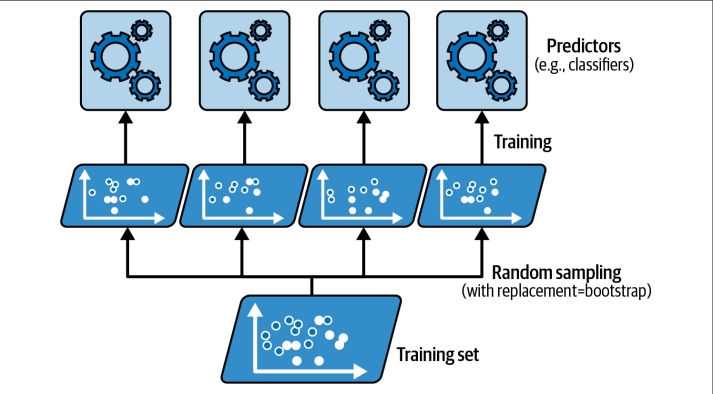

> Bagging en el método que permite reutilizar los datos, es decir que lo saca lo usa y de devuelve para que lo use otro modelo

> Pasting no reutiliza los datos, cada instancia usa datos únicos

Una vez entrenados todos los predictores, el conjunto puede realizar una predicción para una nueva instancia simplemente agregando las predicciones de todos los predictores. La función de agregación suele ser el modo estadístico para la clasificación (es decir, la predicción más frecuente, como en un clasificador de hard voting), o la media para la regresión. Cada predictor individual tiene un sesgo mayor que si se hubiera entrenado con el conjunto de entrenamiento original, pero la agregación reduce tanto el sesgo como la varianza. Generalmente, el resultado neto es que el conjunto tiene un sesgo similar pero una varianza menor que un único predictor entrenado con el conjunto de entrenamiento original.

Como puede verse en la figura, todos los predictores pueden entrenarse en paralelo, a través de diferentes núcleos de CPU o incluso diferentes servidores. Del mismo modo, las predicciones pueden realizarse en paralelo. Esta es una de las razones por las que el bagging y el pasting son métodos tan populares: se escalan muy bien.

## Bagging and Pasting in Scikit-Learn

BaggingClassifier o BaggingRegressor

Scikit-Learn ofrece una API sencilla tanto para el bagging como para el pasting: La clase BaggingClassifier (o BaggingRegressor para regresión). El siguiente código entrena un conjunto de 500 clasificadores de árbol de decisión: cada uno se entrena en 100 instancias de entrenamiento muestreadas aleatoriamente del conjunto de entrenamiento con reemplazo (este es un ejemplo de bagging, pero si desea utilizar pasting en su lugar, simplemente establezca bootstrap=False). El parámetro n_jobs indica a Scikit-Learn el número de núcleos de CPU que debe utilizar para el entrenamiento y las predicciones, y -1 indica a Scikit-Learn que utilice todos los núcleos disponibles:

>> bootstrap=False ---- Es lo que hace que vuelva a usar los datos

In [4]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(DecisionTreeClassifier(), n_estimators=500,
                            max_samples=100, n_jobs=-1, random_state=42)
bag_clf.fit(X_train, y_train)

BaggingClassifier(estimator=DecisionTreeClassifier(), max_samples=100,
                  n_estimators=500, n_jobs=-1, random_state=42)

>> n_jobs = -1 ---- hace que corran todos los modelos en paralelo, en el caso de que no querramos que sea tan lento lo hacemos correr sin eso

Un clasificador Bagging realiza automáticamente un soft voting en lugar de un hard voting si el clasificador base puede estimar las probabilidades de clase (es decir, si tiene un método predict_proba()), que es el caso de los clasificadores de árbol de decisión.


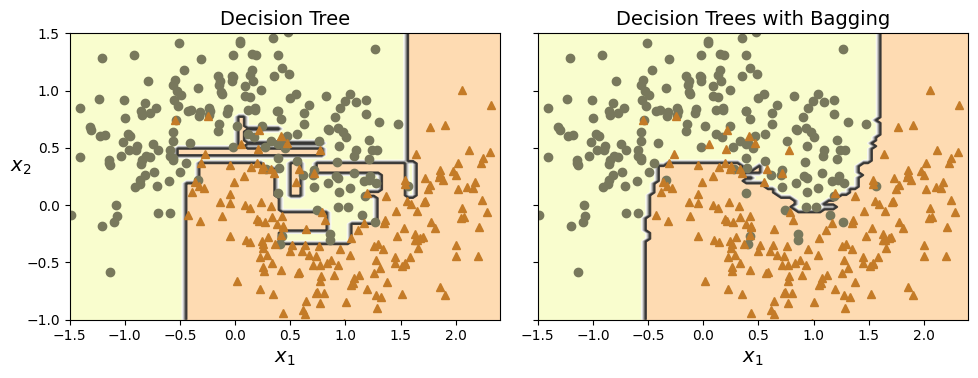

In [5]:

def plot_decision_boundary(clf, X, y, alpha=1.0):
    axes=[-1.5, 2.4, -1, 1.5]
    x1, x2 = np.meshgrid(np.linspace(axes[0], axes[1], 100),
                         np.linspace(axes[2], axes[3], 100))
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    
    plt.contourf(x1, x2, y_pred, alpha=0.3 * alpha, cmap='Wistia')
    plt.contour(x1, x2, y_pred, cmap="Greys", alpha=0.8 * alpha)
    colors = ["#78785c", "#c47b27"]
    markers = ("o", "^")
    for idx in (0, 1):
        plt.plot(X[:, 0][y == idx], X[:, 1][y == idx],
                 color=colors[idx], marker=markers[idx], linestyle="none")
    plt.axis(axes)
    plt.xlabel(r"$x_1$")
    plt.ylabel(r"$x_2$", rotation=0)

tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
plt.sca(axes[0])
plot_decision_boundary(tree_clf, X_train, y_train)
plt.title("Decision Tree")
plt.sca(axes[1])
plot_decision_boundary(bag_clf, X_train, y_train)
plt.title("Decision Trees with Bagging")
plt.ylabel("")
save_fig("decision_tree_without_and_with_bagging_plot")
plt.show()

La figura compara el límite de decisión de un único árbol de decisión con el límite de decisión de un conjunto de 500 árboles, ambos entrenados en el conjunto de datos de lunas. Como puede ver, las predicciones del conjunto probablemente se generalizarán mucho mejor que las predicciones del árbol de decisión único: el conjunto tiene un sesgo comparable pero una varianza menor (comete aproximadamente el mismo número de errores en el conjunto de entrenamiento, pero el límite de decisión es menos irregular).

El bagging introduce un poco más de diversidad en los subconjuntos en los que se entrena cada predictor, por lo que el bagging acaba teniendo un sesgo ligeramente mayor que el pegado; pero la diversidad adicional también significa que los predictores acaban estando menos correlacionados, por lo que se reduce la varianza del conjunto. En general, el bagging suele dar lugar a mejores modelos, lo que explica por qué suele preferirse. Pero si dispone de tiempo y CPU, puede utilizar la Cross Validation para evaluar tanto el bagging como el pasting y seleccionar el que mejor funcione.


## Evaluación fuera de bolsa OOB

Con bagging, algunas instancias de entrenamiento pueden muestrearse varias veces para cualquier predictor dado, mientras que otras pueden no muestrearse en absoluto. Por defecto, un clasificador Bagging muestrea m instancias de entrenamiento con reemplazo (bootstrap=True), donde m es el tamaño del conjunto de entrenamiento. Con este proceso, se puede demostrar matemáticamente que sólo el 63% de las instancias de entrenamiento se muestrean de media para cada predictor. El 37% restante de las instancias de entrenamiento que no se muestrean se denominan instancias fuera de bolsa (OOB). Tenga en cuenta que no es el mismo 37% para todos los predictores.

Un conjunto de bagging puede evaluarse utilizando instancias OOB, sin necesidad de un conjunto de validación separado: de hecho, si hay suficientes estimadores, entonces cada instancia del conjunto de entrenamiento será probablemente una instancia OOB de varios estimadores, por lo que estos estimadores pueden utilizarse para realizar una predicción de conjunto justa para esa instancia. Una vez que tenga una predicción para cada caso, puede calcular la precisión de la predicción del conjunto (o cualquier otra métrica).

En Scikit-Learn, puede establecer oob_score=True al crear un BaggingClassifier para solicitar una evaluación OOB automática después del entrenamiento. El siguiente código lo demuestra. La puntuación de evaluación resultante está disponible en el atributo oob_score_:

In [6]:
bag_clf = BaggingClassifier(DecisionTreeClassifier(), n_estimators=500,
                            oob_score=True, n_jobs=-1, random_state=42)
bag_clf.fit(X_train, y_train)
bag_clf.oob_score_

0.896

Según esta evaluación OOB, es probable que este BaggingClassifier consiga una precisión del 89,6% en el conjunto de prueba. Verifiquemos esto:

In [7]:
from sklearn.metrics import accuracy_score

y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.92

In [8]:
bag_clf.oob_decision_function_[:3]  # probas para las 3 primeras instancias

array([[0.32352941, 0.67647059],
       [0.3375    , 0.6625    ],
       [1.        , 0.        ]])

Obtenemos un 92% de precisión en la prueba. La evaluación OOB fue un poco pesimista, algo más de un 2% demasiado baja. La función de decisión OOB para cada instancia de entrenamiento también está disponible a través del atributo oob_decision_function_. Dado que el estimador base tiene un método predict_proba(), la función de decisión devuelve las probabilidades de clase para cada instancia de entrenamiento. Por ejemplo, la evaluación OOB estima que la primera instancia de entrenamiento tiene una probabilidad del 67,6% de pertenecer a la clase positiva y una probabilidad del 32,4% de pertenecer a la clase negativa:

Si se extrae aleatoriamente una instancia de un conjunto de datos de tamaño _m_, cada instancia del conjunto de datos tiene obviamente una probabilidad 1/_m_ de ser elegida y, por lo tanto, tiene una probabilidad 1 - 1/_m_ de _no_ ser elegida. Si se extraen _m_ instancias con reemplazo, todas las extracciones son independientes y, por tanto, cada instancia tiene una probabilidad (1 - 1/_m_)<sup>m_</sup> de _no_ ser escogida. Ahora utilicemos el hecho de que exp(_x_) es igual al límite de (1 + _x_/_m_)<sup>m_</sup> a medida que _m_ se acerca a infinito. Así que si _m_ es grande, la proporción de instancias fuera de la bolsa será aproximadamente exp(-1) ≈ 0,37. Así que aproximadamente el 63% (1 - 0,37) será muestreado.

In [9]:
print(1 - (1 - 1 / 1000) ** 1000)
print(1 - np.exp(-1))

0.6323045752290363
0.6321205588285577
